***Assignment 2***
by Magnus A. Nielsen (s204072) & Philip J. F. Helsted (s204147)
GitHub:
**Contribution statement**
all work has been done cooperatively

In [2]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import css_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Loading graph from week4
css_graph = css_utils.read_json_file("data/graph.json")

# Setting random seed
np.random.seed(79)

**Part 1: Mixing Patterns and Assortativity**

In [4]:
# Removing nodes with no top_field
for author in list(css_graph.nodes):
    css_utils.remove_node_if_no_field(css_graph, author)

In [5]:
# For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.
top_field_frac = np.mean([css_utils.edge_same_top_field(edge, css_graph) for edge in list(css_graph.edges)])
top_field_frac

0.5105415002219263

In [6]:
# Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled.
# Compute the measure above for this randomized graph.
# Repeated 500 times
results = []
N_repeat = 500
graph_copy = css_graph.copy()

for i in tqdm(range(N_repeat)):
    results.append(css_utils.randomize_field_get_mean(graph_copy, css_utils.get_field_list(css_graph)))

100%|██████████| 500/500 [00:15<00:00, 32.85it/s]


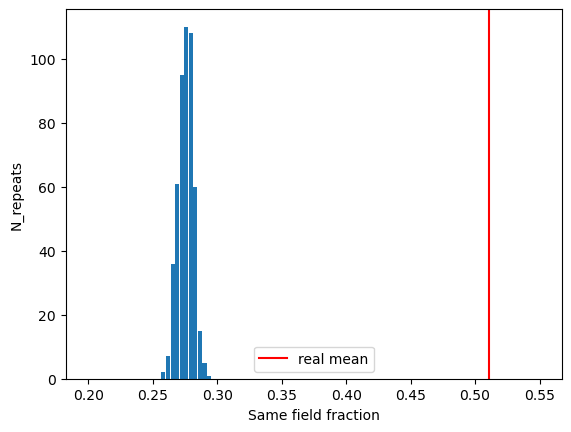

In [7]:
bins = np.linspace(0.2, 0.55, 100)
hist, edges = np.histogram(results, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, axs = plt.subplots()
axs.bar(x, hist, width=width*0.9)

axs.set_xlabel('Same field fraction')
axs.set_ylabel('N_repeats')
axs.axline((top_field_frac, 0), (top_field_frac, max(results)), color='red', label='real mean')
axs.legend()
plt.show()

*Is the chance to connect to a member of the same field significantly higher than it would be by chance?*
When the association between nodes and field are randomized, the mean value we obtain for the connections is significantly lower than what we see in the real graph. The real graph has a mean value of 0.51, whereas the randomized graphs have a mean around 0.275. This means that in the real world there is a clear tendency to connect with people that work in the same field as yourself.

In [9]:
# Compute the assortativity coefficient with respect to author's field.
# How do you interpret the value you obtain? (Hint: See this paper, eq (2)).
# Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.
fields_unique = np.unique(css_utils.get_field_list(css_graph))
fields_unique_n = len(fields_unique)

field_index = {}

for i in range(fields_unique_n): # Use this index for matrix
    field_index[fields_unique[i]] = i

degree_max = np.max([t[1] for t in list(css_graph.degree)])
field_matrix = np.zeros((fields_unique_n-1, fields_unique_n-1)) # -1 to avoid the nan which is included in fields unique
degree_matrix = np.zeros((44, 44))

for edge in list(css_graph.edges): # For all edges, increment related matrix values

    field_a = css_graph.nodes[edge[0]]['top_field']
    field_b = css_graph.nodes[edge[1]]['top_field']

    deg_a = css_graph.degree[edge[0]]
    deg_b = css_graph.degree[edge[1]]

    degree_matrix[deg_a, deg_b] += 1
    degree_matrix[deg_b, deg_a] += 1

    try:
        field_a_index = field_index[field_a]
        field_b_index = field_index[field_b]

        field_matrix[field_a_index, field_b_index] += 1
        field_matrix[field_b_index, field_a_index] += 1

    except: # Some fields are nan, do nothing
        pass

field_matrix = field_matrix.astype(int)
field_matrix = np.divide(field_matrix, np.sum(field_matrix))

degree_matrix = np.divide(degree_matrix, np.sum(degree_matrix))

In [10]:
r_field = (np.trace(field_matrix) - np.sum(field_matrix**2))/(1-np.sum(field_matrix**2))
r_degree = (np.trace(degree_matrix) - np.sum(degree_matrix**2))/(1-np.sum(degree_matrix**2))

In [16]:
print("Assortativity coefficient for field: ", round(r_field, 3))
print("Assortativity coefficient for degree: ", round(r_degree, 3))


Assortativity coefficient for field:  0.432
Assortativity coefficient for degree:  0.473


**Part 2: Communities**

In [18]:
# imports
from netwulf.interactive import visualize

**Part 3: TF-IDF**


In [119]:
tf_idf_data = pd.read_csv("data/TF_IDF_DATA.csv")
tokenized_abstract = pd.read_csv("data/tokenized_abstract.csv")
css_papers = pd.read_csv("data/css_papers.csv")
sorted_data = tf_idf_data.sort_values('Community', axis='index')

In [137]:
for i in range(max(sorted_data['Community'])):


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [127]:
counter = 0
for paperId in css_papers['paperId']:
    if paperId in tokenized_abstract['paper_id'].tolist():
        counter += 1

print(f'{counter} out of {len(css_papers)} have tokenized abstracts.')

3339 out of 4915 have tokenized abstracts.
